## Two compartment IV-Infusion model
This notebook implements the two compartment IV-Infusion model. Here we infuse the drug intravenously at a constant rate (say R). Here, I have performed the simulation studies of drug elimination with a rate constant k10 and redistribution between central and peripheral compartments respectively with rates k12 and k21. Noise is added to mimic the experimental data of time variation of concetration of the drug and parameter estimation has been performed.

---

##  1. Import Required Libraries
We will use:
- `numpy` for numerical computation  
- `matplotlib` for plotting  
- `scipy.integrate.solve_ivp` for solving differential equations  
- `scipy.optimize.least_squares` for parameter estimation


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

##  2. Define the Two-Compartment ODE System

We consider two compartments:
- **Central compartment (A₁)** – where the drug mixing is very fast.
- **Peripheral compartment (A₂)** – where the drug mixing is slow. 
The model equations are:

$$
\frac{dA_1}{dt} = R -(k_{10} + k_{12})A_1 + k_{21}A_2
$$


$$
\frac{dA_2}{dt} = k_{12}A_1 - k_{21}A_2
$$

where  
- R: Constant rate of infusion.
- $k_{10}$: elimination rate constant (from central)  
- $k_{12}$: distribution rate constant (central → peripheral)  
- $k_{21}$: redistribution rate constant (peripheral → central)

In [17]:
def IV_infusion_2C_ode(t, y, R, k10, k12, k21):
    A1, A2 = y
    dA1dt = R - (k10 + k12)*A1 + k21*A2
    dA2dt = k12*A1 - k21*A2
    return dA1dt, dA2dt

##  3. Function to Solve the ODEs

This function integrates the ODEs using `solve_ivp` and returns:
- Amounts in each compartment ($A_1$, $A_2$)
- Corresponding concentrations ($C_1 = A_1/V_1$, $C_2 = A_2/V_2$)


In [18]:
def solution_ivp(times, y0, params):
    R, V1, V2, k10, k12, k21 = params
    sol = solve_ivp(lambda tt, y: IV_infusion_2C_ode(tt, y, R, k10, k12, k21), (times[0], times[-1]), y0, t_eval=times)
    A1, A2 = sol.y
    C1 = A1/V1
    C2 = A2/V2
    return C1, A1, C2, A2

##  4. Define True Model Parameters and Concentrations

Here, initially the concentration of the drug in the two compartments are zero. 

In [24]:
#params_true = [R, V1, V2, k10, k12, k21]
params_true = [0.5, 50, 50, 0.12, 0.12, 0.12]
times = np.linspace(0, 240, 2001)
y0 = [0, 0]
C1_true, A1_true, C2_true, A2_true = solution_ivp(times, y0, params_true)

# 5. Generate Synthetic Observed Data

We simulate noisy observed concentrations by adding Gaussian noise (σ = 0.3 mg/L) to the model predictions that mimics the experimental data.


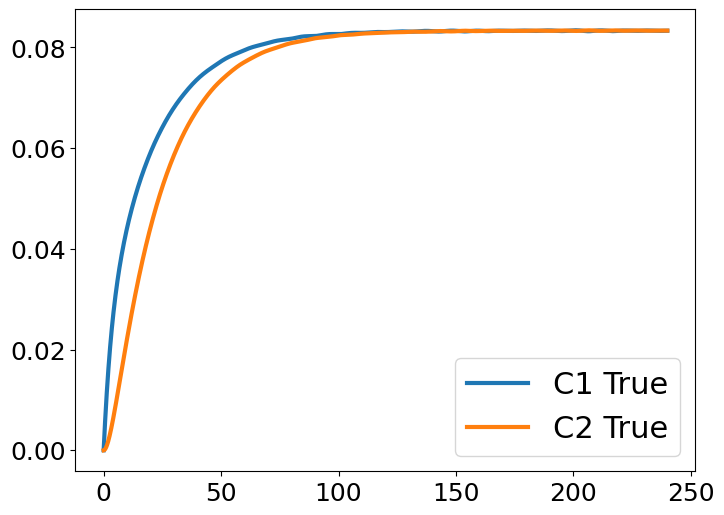

In [25]:
C1_obs = C1_true + np.random.normal(0, 0.003, len(C1_true))
C2_obs = C2_true + np.random.normal(0, 0.003, len(C2_true))

plt.plot(times, C1_true, label="C1 True")
plt.plot(times, C2_true, label="C2 True")

plt.legend()
plt.show()

## 6. Define the Residual Function for Parameter Fitting
We calculate the residue as the difference between the observed data and the model predicted concentrations. Here, the fitting will adjust the parameters `[R, V1, V2, k10, k12, k21]` to minimize the sum of the squared residual.

In [26]:
def residuals_pk(p):
    if np.any(np.array(p) <= 0):
        return 1e6 * np.ones(2 * len(times)) 
    C1_model, A1_model, C2_model, A2_model = solution_ivp(times, y0, p)
    res = np.concatenate([(C1_model - C1_obs), (C2_model - C2_obs)])
    return res


## 7. Parameter Estimation using Nonlinear Least Squares

We use `scipy.optimize.least_squares` to find the parameters that minimize the residuals.

In [27]:
p0 = [0.5, 40.0, 40.0, 0.12, 0.12, 0.12]
lower = [1e-6, 1e-3, 1e-3, 1e-6, 1e-6, 1e-6]
upper = [10.0, 1000.0, 1000.0, 10.0, 10.0, 10.0]

res = least_squares(residuals_pk, p0, bounds=(lower, upper))
print("Estimated parameters:", res.x)

# Compare model fit
C1_fit, A1_fit, C2_fit, A2_fit = solution_ivp(times, y0, res.x)

Estimated parameters: [ 0.49448946 48.051807   50.14132124  0.12350076  0.12385071  0.1187402 ]


##  8. Compare Model Fit vs Observed Data
We visualize how well the fitted model reproduces the observed (noisy) concentration–time profiles for both compartments.

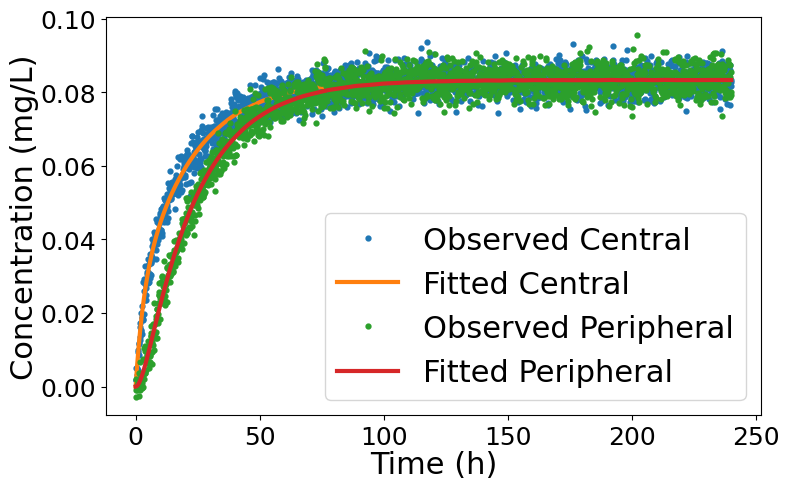

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(times, C1_obs, 'o', label="Observed Central", markersize=3)
plt.plot(times, C1_fit, '-', label="Fitted Central")
plt.plot(times, C2_obs, 'o', label="Observed Peripheral", markersize=3)
plt.plot(times, C2_fit, '-', label="Fitted Peripheral")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (mg/L)")
plt.legend()
plt.tight_layout()
plt.show()
    

##  9. Steady State Analysis
We calculate the analytical steady state concentration of central comparment and verify this with numerical simulation of the IV infusion model. We also obtain the time scale at which the steady state is reached.

In [50]:
def steady_state_analysis(t, C, params, rel_tolerance=0.01, slope_tolerance=1e-6, window=5):
    R, V1, V2, k10, k12, k21 = params
    C_SS_theory = R/(k10 * V1)
    C_last = C[-1]
    C_last_mean = np.mean(C[-window:]) if (len(C) >= window) else C_last
    rel_error_last = abs(C_last_mean - C_SS_theory)/ (C_SS_theory if C_SS_theory != 0 else 1.0)

    if C_SS_theory != 0:
        idx_Css = np.where(abs(C - C_SS_theory)/ (C_SS_theory) <= rel_tolerance)[0]
        t_converge = float(t[idx_Css[0]]) if idx_Css.size > 0 else np.nan
    else:
        t_convege = np.nan

    dcdt = np.gradient(C, t)
    slope_at_end = dcdt[-1]
    slope_test = abs(slope_at_end) <= slope_tolerance

    return {
        'C_theory': C_SS_theory,
        'C_last_mean': C_last_mean,
        'rel_error_last': rel_error_last,
        't_converge_rel_tol': t_converge,
        'slope_at_end': slope_at_end,
        'slope_test_pass': slope_test
    }

checks = steady_state_analysis(times, C1_true, params_true, rel_tolerance=0.01, slope_tolerance=1e-4, window=5)
print("Analytic C_ss:", checks['C_theory'])
print("Numeric last-mean C:", checks['C_last_mean'])
print("Relative error (last mean vs analytic): {:.4f}%".format(checks['rel_error_last']*100))
print("Time to reach within 1% of C_ss (first time):", checks['t_converge_rel_tol'], "hours")
print("Slope at end (dC/dt):", checks['slope_at_end'], "units/hour")
print("Slope test pass (abs(slope) <= tol):", checks['slope_test_pass'])

    

Analytic C_ss: 0.08333333333333333
Numeric last-mean C: 0.0833161482541302
Relative error (last mean vs analytic): 0.0206%
Time to reach within 1% of C_ss (first time): 93.36 hours
Slope at end (dC/dt): 4.8352768123916e-06 units/hour
Slope test pass (abs(slope) <= tol): True
